In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from sklearn.decomposition import PCA
import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
#from dask.distributed import Client
#client = Client()  # start distributed scheduler locally.
#client
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter1d
import re
import random


# Select modalities, events, parameters 

In [169]:
# List with optional commented-out modalities
modalities = [
    'NoseVector.x',        
    'NoseVector.y',          
    'EyeDirWorldCombined.x', 
    'EyeDirWorldCombined.y',  
    #'EyeDirLocalCombined.x',        
    #'EyeDirLocalCombined.y',        
    'SteeringInput',         
]


# --- Toggle events by commenting them out ---
event_filter_list = [   
    #'NoEvent', # UNCOMMENT THIS TO INCLUDE ALL EVENTS
    
    'StagEventNew',        
    #'FallingRocksEventNew',
    #'FogEventNew',         
    #'I_variant',           
    #'III_variant',
    #'MarketPlaceEvent',
    #'CyclistEvent',       
    # 'Panne',                  
    # 'GhostDriver',
    # 'Baustelle',          
    #'MotorcyclistEvent'    ,
]


#for the raw data plotting 
#condition_filter = 'BaseCondition'
#condition_filter = '!BaseCondition'
#condition_filter = 'HUDOnly'
#condition_filter = 'AudioOnly'
#condition_filter = 'FullLoopAR'
condition_filter = 'All Conditions'



outlier_features =  ['EyeDirWorldCombined.x', 'NoseVector.x', 'EyeDirWorldCombined.y', 'NoseVector.y', 'SteeringInput']#  , 'EyeDirWorldCombined.z', 'NoseVector.z'     remove as needed



points_per_window = 501  # 10 seconds @ 50Hz, plus onset frame in the middle
T = points_per_window
global_sigma = 0.000001    # smoothing strength 




Define and load dataframe

In [158]:
# Define dtypes to load all uid files
dtypes = {
    'uid': 'str',
    'dataset': 'str',
    'city_section': 'str',
    'ExperimentalCondition': 'str',
    'EventName': 'object',
    'HitObjectName': 'object',
    'ObjectName_4': 'object',
    'ObjectName_5': 'object',
    'EventDuration': 'float64',
    'TimeStamp': 'float64'
}

# Define the path to the CSV file
dir = os.getcwd()
data_path = dir + '/data/'
# Load your specific file 
len_outlier_features = len(outlier_features)
event_name = event_filter_list[0]  # e.g., 'FogEventNew'

filepath = data_path + f"/cleaned_data/data_segment/outliers_removed_{len_outlier_features}features/steeringRemoved/segment_around_{event_name}_nearest_neighbor_steeringRemoved.csv" #x 



df = dd.read_csv(filepath, assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False).compute()

print("DataFrame shape before event filtering:", df.shape)

# Assuming event_filter_list and condition_filter are defined elsewhere, for example:
# condition_filter = 'All Conditions'  # or other condition to filter on

# Filter for participants (uids) that have any of the events in event_filter_list
uids_with_events = df[df['EventName'].isin(event_filter_list)]['uid'].unique()
filtered_df = df[df['uid'].isin(uids_with_events)]

print(f"DataFrame shape after filtering for event presence ({len(uids_with_events)} uids):", filtered_df.shape)

# Further filter by experimental condition if specified
if condition_filter != 'All Conditions':
    if condition_filter == '!BaseCondition':
        filtered_df = filtered_df[filtered_df['ExperimentalCondition'] != 'BaseCondition']
        condition_filter = "Any warning (non-control)"
    else:
        filtered_df = filtered_df[filtered_df['ExperimentalCondition'] == condition_filter]

print("DataFrame shape after condition filtering:", filtered_df.shape)

# Check that required columns exist
if 'uid' not in filtered_df.columns:
    raise ValueError("❌ 'uid' column missing in the filtered dataframe")


DataFrame shape before event filtering: (80160, 89)
DataFrame shape after filtering for event presence (160 uids): (80160, 89)
DataFrame shape after condition filtering: (80160, 89)


Plot raw data for each modality

In [159]:
# # Centering and standardizing data for each observation (participant's data per modality)
# raw_all_participant_curves = []

# for (uid), sub_df in filtered_df.groupby(['uid']):

#     if not all(col in sub_df.columns for col in modalities):
#         continue

#     data = sub_df[modalities].copy()
    
#     raw_all_participant_curves.append(data.T)

# if len(raw_all_participant_curves) == 0:
#     raise ValueError("❌ No valid participant data found!")

# # Stack to 3D array: (N_windows, T, M)
# raw_data_array = np.stack(raw_all_participant_curves, axis=0)  # shape: (W, M, T)
# raw_data_array = np.transpose(raw_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

# W, T, M = raw_data_array.shape
# print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")
# time_sec = np.linspace(-5, 5, T)# Loop through each modality (M) and plot the data for each participant
# for m in range(M):
#     # Extract modality-specific data
#     raw_modality_data = raw_data_array[:, :, m]  # Shape: (W, T)
    
#     # Debug: Check the shape of the modality data
#     print(f"Modality {m} data shape: {raw_modality_data.shape}")

#     # Create a new figure for each modality
#     plt.figure(figsize=(10, 6))

#     # Plot the raw time series for each participant
#     for participant_data in raw_modality_data:
#         plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

#     # Compute and plot the mean time series across participants
#     raw_mean_data = raw_modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
#     # Debug: Check the mean data
#     print(f"Mean data for modality {m}: {raw_mean_data[:5]}")  # Print first few values of mean data
    
#     # Get the modality name from the modalities list
#     modality_name = modalities[m]  # Assuming modalities is a list of names
    
#     plt.plot(time_sec, raw_mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

#     plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#     plt.xlabel("Time (s)")
#     plt.ylabel(f"Modality {modality_name} Values")
#     plt.title(f"Raw Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
#     # Set y-axis limits
#     plt.ylim(-1, 1)

#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


Plot centered and standardized variables

In [160]:
# # Centering and standardizing data for each observation (participant's data per modality)
# all_participant_curves = []

# for (uid), sub_df in filtered_df.groupby(['uid']):
#     if len(sub_df) != points_per_window:
#         print(len(sub_df),points_per_window),
#         continue  # Skip incomplete windows

#     if not all(col in sub_df.columns for col in modalities):
#         continue

#     data = sub_df[modalities].copy()

#     # Center each participant's data (curve) on its own mean
#     for modality_idx in range(data.shape[1]):
#         modality_data = data.iloc[:, modality_idx].values  # Extract modality data for current participant
#         modality_data_centered = modality_data - modality_data.mean()  # Center the data
#         data.iloc[:, modality_idx] = modality_data_centered  # Replace the modality with centered data
    
#     # Standardize each modality's data across all participants
#     scaler = StandardScaler()
#     data_scaled = scaler.fit_transform(data)
    
#     all_participant_curves.append(data_scaled.T)

# if len(all_participant_curves) == 0:
#     raise ValueError("❌ No valid participant data found!")

# # Stack to 3D array: (N_windows, T, M)
# Pca_data_array = np.stack(all_participant_curves, axis=0)  # shape: (W, M, T)
# Pca_data_array = np.transpose(Pca_data_array, (0, 2, 1))  # Convert to shape (W, T, M)

# W, T, M = Pca_data_array.shape
# print(f"Loaded {W} valid windows, shape = ({W}, {T}, {M})")
# time_sec = np.linspace(-5, 5, T)

# # # Loop through each modality (M) and plot the data for each participant
# for m in range(M):
#     # Extract modality-specific data
#     modality_data = Pca_data_array[:, :, m]  # Shape: (W, T)
    
#     # Debug: Check the shape of the modality data
#     print(f"Modality {m} data shape: {modality_data.shape}")

#     # Create a new figure for each modality
#     plt.figure(figsize=(10, 6))

#     # Plot the raw time series for each participant
#     for participant_data in modality_data:
#         plt.plot(time_sec, participant_data, color='lightgray', alpha=0.5)  # Raw data

#     # Compute and plot the mean time series across participants
#     mean_data = modality_data.mean(axis=0)  # Mean across participants, shape: (T,)
    
#     # Debug: Check the mean data
#     print(f"Mean data for modality {m}: {mean_data[:5]}")  # Print first few values of mean data
    
#     # Get the modality name from the modalities list
#     modality_name = modalities[m]  # Assuming modalities is a list of names
    
#     plt.plot(time_sec, mean_data, label=f"Mean {modality_name}", color='blue', linewidth=2)  # Mean line

#     plt.axvline(0, color='black', linestyle='--', label="Event Onset (0s)")
#     plt.xlabel("Time (s)")
#     plt.ylabel(f"Modality {modality_name} Values")
#     plt.title(f"Standardized Time Series for {modality_name}, {event_filter_list} , {condition_filter}")
    
#     # Set y-axis limits
#     plt.ylim(-3, 3)

#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


# Time-wise PCA ED Curve

# PCA Settings

In [161]:
# global_sigma = 0.00001  # smoothing strength

# --- Define condition filters ---
condition_filters = [
    #'BaseCondition', 
    #'!BaseCondition',
    #'HUDOnly', 
    #'AudioOnly', 
    #'FullLoopAR', 
    'All Conditions'
    #'Success',
    #'Failure'
]

if "Success" in condition_filters:
    # List of colors for each condition
    colors = {

        'Success': 'green',
        'Failure': 'red'} 
else:
    colors = {
        'BaseCondition': 'pink',
        '!BaseCondition': 'black',
        'HUDOnly': 'orange',
        'AudioOnly': 'blue',
        'FullLoopAR': 'yellow',
        'All Conditions': 'purple',  
    }


print(colors)

# Load and filter


df = dd.read_csv(filepath, assume_missing=True, dtype=dtypes, blocksize="100MB").compute()

grouped = df.groupby('uid')
event_filtered = grouped.filter(lambda x: any(event in x['EventName'].values for event in event_filter_list))

event_filtered.shape

lineW = 2

{'BaseCondition': 'pink', '!BaseCondition': 'black', 'HUDOnly': 'orange', 'AudioOnly': 'blue', 'FullLoopAR': 'yellow', 'All Conditions': 'purple'}


# PCA with both per curve and per time point standardization

In [162]:
def process_and_plot_ed(event_filtered, event_name, condition_filters, modalities,
                        points_per_window, colors, analysis_mode="warnings", local_sigma=global_sigma):
    """
    Unified function to process Effective Dimensionality (ED) curves
    for either 'warnings' (BaseCondition etc.) or 'success' (Success/Failure),
    and plot ED - ID with smoothed + raw overlay.
    """

    plt.figure(figsize=(14, 8))
    sample_sizes = {}
    ed_curves_by_condition = {}

    if analysis_mode == "warnings":
        buffer_file = f"data/ed_buffer_{len(modalities)}modalities_warnings.csv"
        cond_iter = condition_filters
        lineW = 1
    elif analysis_mode == "success":
        buffer_file = f"data/ed_buffer_{len(modalities)}modalities_success.csv"
        cond_iter = ["Success", "Failure"]
        lineW = 2
    else:
        raise ValueError("analysis_mode must be either 'warnings' or 'success'.")

    for condition_filter in cond_iter:

        # ------------------ FILTER PARTICIPANTS ------------------
        if analysis_mode == "warnings":
            if condition_filter == 'BaseCondition':
                cond_df = event_filtered[event_filtered['ExperimentalCondition'] == 'BaseCondition']
            elif condition_filter == '!BaseCondition':
                cond_df = event_filtered[event_filtered['ExperimentalCondition'] != 'BaseCondition']
            elif condition_filter == 'All Conditions':
                cond_df = event_filtered.copy()
            else:
                cond_df = event_filtered[event_filtered['ExperimentalCondition'] == condition_filter]

        elif analysis_mode == "success":
            if condition_filter == 'Success':
                successful_uids = event_filtered.groupby('uid')['SuccessfulCompletionState'].max()
                successful_uids = successful_uids[successful_uids == True].index   # ✅ match True
                cond_df = event_filtered[event_filtered['uid'].isin(successful_uids)]
            elif condition_filter == 'Failure':
                failed_uids = event_filtered.groupby('uid')['SuccessfulCompletionState'].max()
                failed_uids = failed_uids[failed_uids == False].index  # ✅ match False
                cond_df = event_filtered[event_filtered['uid'].isin(failed_uids)]




        # ------------------ BUILD CURVES ------------------
        all_participant_curves = []
        for _, sub in cond_df.groupby('uid'):
            if len(sub) != points_per_window:
                continue
            data = sub[modalities].copy()
            data_scaled = StandardScaler().fit_transform(data)
            all_participant_curves.append(data_scaled.T)

        n_participants = len(all_participant_curves)
        sample_sizes[condition_filter] = n_participants
        print(f"{condition_filter}: {n_participants} participants included")

        if n_participants == 0:
            continue

        # stack into (W, T, M)
        Pca_data_array = np.stack(all_participant_curves, axis=0)          # (W, M, T)
        Pca_data_array = np.transpose(Pca_data_array, (0, 2, 1))           # (W, T, M)
        W, T, M = Pca_data_array.shape
        
        # ------------------ COVARIANCE + ED ------------------
        cov_matrix = np.zeros((T, M, M))
        steering_idx = modalities.index('SteeringInput') if 'SteeringInput' in modalities else None

        for t in range(T):
            snap = Pca_data_array[:, t, :]
            snap -= snap.mean(axis=0)

            if t < 251 and steering_idx is not None:
                snap[:, steering_idx] = 0

            for m in range(M):
                if steering_idx is not None and m == steering_idx and t < 251:
                    continue
                std = snap[:, m].std(ddof=1)
                if std > 1e-12:
                    snap[:, m] /= std

            cov_matrix[t] = snap.T @ snap / (W - 1)

        ed_curve = []
        for t in range(T):
            eig = eigh(cov_matrix[t], eigvals_only=True)
            p = eig / np.sum(eig)
            ed_curve.append(1 / np.sum(p**2))

        secs = np.linspace(-5, 5, T)
        ed_curves_by_condition[condition_filter] = np.array(ed_curve)

        # ------------------ SAVE TO BUFFER ------------------
        ed_df = pd.DataFrame({
            'time_sec': secs,
            'ED': ed_curve,
            'event_name': event_name,
            'condition': condition_filter
        })
        if os.path.exists(buffer_file):
            existing = pd.read_csv(buffer_file)
            exists_pair = (
                (existing['event_name'] == event_name) &
                (existing['condition'] == condition_filter)
            ).any()
            if exists_pair:
                print(f"⏩ Skipping {event_name} ({condition_filter}) - already in buffer")
            else:
                combined = pd.concat([existing, ed_df], ignore_index=True)
                combined.to_csv(buffer_file, index=False)
                print(f"✅ Appended ED curve for: {event_name} ({condition_filter})")
        else:
            ed_df.to_csv(buffer_file, index=False)
            print(f"✅ Created new ED buffer file for: {event_name} ({condition_filter})")

    # ------------------ FINAL PLOT (ED - ID) ------------------
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel("ED - ID")

    #secs = np.linspace(-5, 5, T)

    # Define ID curve
    if 'SteeringInput' in modalities:
        id_curve = np.where(secs <= 0, len(modalities)-1, len(modalities))
    else:
        id_curve = np.where(secs <= 0, len(modalities), len(modalities))

    for condition_filter, ed_curve_cond in ed_curves_by_condition.items():
        ed_minus_id = ed_curve_cond - id_curve

        # Smooth
        smoothed_ed_minus_id = gaussian_filter1d(ed_minus_id, sigma= local_sigma)

        # Overlay raw wriggles (light alpha)
        plt.plot(
            secs, ed_minus_id,
            color=colors[condition_filter],
            linewidth=1,
            alpha=0.2
        )

        # Plot smoothed (main line, with legend)
        plt.plot(
            secs, smoothed_ed_minus_id,
            label=f'{condition_filter} (ED - ID, smoothed)',
            color=colors[condition_filter],
            linewidth=lineW
        )

    plt.ylim(-(len(modalities)-1), 0)
    plt.title(f"Time-wise ED - ID Curve of {modalities} — {analysis_mode}, {event_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return sample_sizes, T, ed_curves_by_condition


All Conditions: 160 participants included
✅ Created new ED buffer file for: StagEventNew (All Conditions)


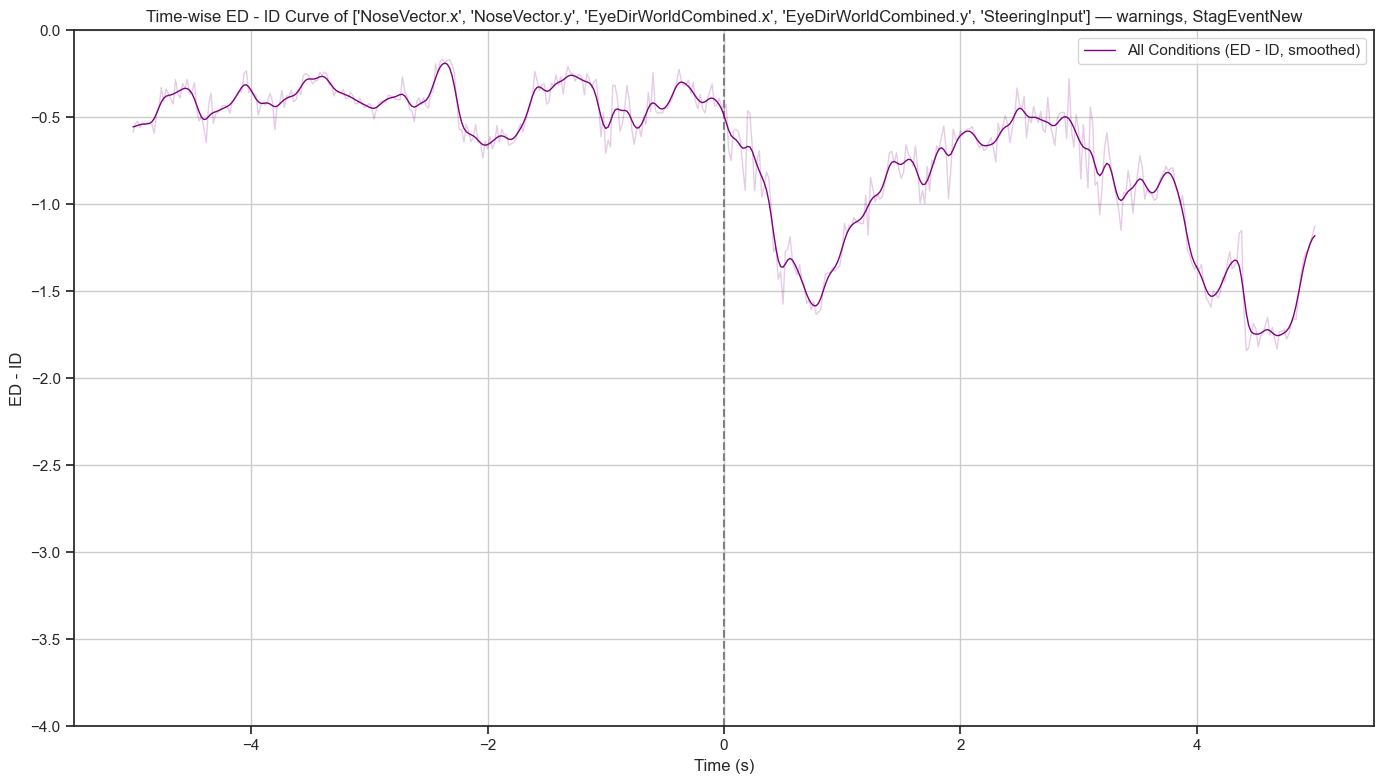

({'All Conditions': 160},
 501,
 {'All Conditions': array([3.41351914, 3.4631153 , 3.47764823, 3.44256899, 3.46962008,
         3.45988404, 3.4690771 , 3.46532049, 3.45914704, 3.40807405,
         3.52603333, 3.55604745, 3.67206234, 3.59140137, 3.66337874,
         3.63339852, 3.60631025, 3.57743083, 3.71693727, 3.63492564,
         3.61296183, 3.69533752, 3.66760451, 3.71856406, 3.63338609,
         3.64864007, 3.70127828, 3.54352262, 3.47924436, 3.50695849,
         3.43788243, 3.35316702, 3.57172599, 3.63939098, 3.46478253,
         3.52085132, 3.52884863, 3.54655694, 3.56739747, 3.56754433,
         3.55979459, 3.52454885, 3.59170101, 3.60890416, 3.62938391,
         3.65106613, 3.64703401, 3.75119846, 3.76805642, 3.6413507 ,
         3.66117612, 3.63562975, 3.62928882, 3.51441773, 3.56517579,
         3.58959581, 3.56989338, 3.5980261 , 3.63727193, 3.59368464,
         3.42934245, 3.56379074, 3.57573856, 3.65583403, 3.55673934,
         3.62395613, 3.61941341, 3.65662948, 3.589728

In [163]:
local_sigma = 2  # smoothing strength for local analysis (warnings)

process_and_plot_ed(event_filtered, event_name, condition_filters,
                    modalities, points_per_window, colors,
                    analysis_mode="warnings", local_sigma=local_sigma)

# or

# process_and_plot_ed(event_filtered, event_name, condition_filters,
#                     modalities, points_per_window, colors,
#                     analysis_mode="success")


# Multiple events aggragated

In [164]:
def plot_ed_for_modalities(num_modalities, analysis_mode="warnings"):
    """
    Plot ED curves with either warning conditions or success/failure.
    analysis_mode: "warnings" or "success"
    Uses the 'colors' variable from previous cells.
    Counts total events correctly from the file, not per condition.
    """

    # --- pick buffer file based on analysis mode ---
    buffer_file = f"data/ed_buffer_{num_modalities}modalities_{analysis_mode}.csv"

    if not os.path.exists(buffer_file):
        raise FileNotFoundError(f"No buffer file found at {buffer_file}.")

    df_all = pd.read_csv(buffer_file)

    # --- filter conditions based on mode ---
    if analysis_mode == "warnings":
        valid_conditions = ['BaseCondition', '!BaseCondition', 'HUDOnly', 'AudioOnly', 'FullLoopAR']
        lineW = 1
    elif analysis_mode == "success":
        valid_conditions = ['Success', 'Failure']
        lineW = 2
    else:
        raise ValueError("analysis_mode must be 'warnings' or 'success'")

    df_all = df_all[df_all['condition'].isin(valid_conditions)]

    # --- get total unique events across the file ---
    unique_events_in_file = df_all['event_name'].unique()
    total_event_count = len(unique_events_in_file)
    print(f"Detected events in file: {list(unique_events_in_file)}")
    print(f"Using modalities from previous list: {modalities}")

    plt.figure(figsize=(14, 7))

    for condition_name, group_df in df_all.groupby('condition'):
        # unique events in this condition
        unique_events_in_condition = group_df['event_name'].nunique()
        agg_df = group_df.groupby('time_sec')['ED'].mean().reset_index()

        # Use colors from external colors variable
        plt.plot(
            agg_df['time_sec'], agg_df['ED'],
            label=f'{condition_name} ({unique_events_in_condition} events)',
            color=colors[condition_name],
            linewidth=lineW
        )

    plt.axvline(0, color='gray', linestyle='--', label='Event onset')
    plt.xlabel('Time (s)')
    plt.ylabel('Effective Dimensionality (ED)')
    plt.title(f'Aggregated ED curves ({total_event_count} events total, {num_modalities} modalities, mode= {analysis_mode})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # --- ID - ED Plot (only if SteeringInput is present) ---
    # --- ID - ED Plot (only if SteeringInput is present) ---
    print("Generating ID - ED plot...")

    plt.figure(figsize=(14, 7))

    for condition_name, group_df in df_all.groupby('condition'):
        ed_by_time = group_df.groupby('time_sec')['ED'].mean().reset_index()
        secs = ed_by_time['time_sec'].values
        ed = ed_by_time['ED'].values
        
        if 'SteeringInput' in modalities:

        # Define ID curve
            id_curve = np.where(secs <= 0, num_modalities - 1, num_modalities)
        else:
            id_curve = np.where(secs <= 0, num_modalities, num_modalities)

        # Compute difference
        ed_minus_id = ed - id_curve
        smoothed_diff = gaussian_filter1d(ed_minus_id, sigma=2)  # adjust sigma for more/less smoothing

        # Plot raw difference (no legend)
        plt.plot(
            secs, ed_minus_id,
            color=colors[condition_name],
            linewidth=lineW,
            alpha=0.2
        )

        # Plot smoothed difference (with legend)
        plt.plot(
            secs, smoothed_diff,
            label=f'{condition_name} (ED - ID, smoothed)',
            color=colors[condition_name],
            linewidth=lineW
        )

    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--', label='Onset (0s)')
    plt.xlabel("Time (s)")
    plt.ylabel("ED - ID")
    plt.title(f"Dimensionality Gap Over Time (ED - ID)\n{num_modalities} modalities with SteeringInput ({analysis_mode})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [165]:

# plot_ed_for_modalities(len(modalities), analysis_mode="warnings")
# #plot_ed_for_modalities(len(modalities), analysis_mode="success")


In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pre_post_permutation_ed(buffer_file, event_name, modalities, threshold_std=2, n_permutations=1000):
    """
    Permutation-based cluster test comparing post-onset ED-ID curve to pre-onset baseline.

    Parameters
    ----------
    buffer_file : str
        CSV file containing ED curves (columns: time_sec, ED, condition, event_name)
    event_name : str
        Event to analyze
    modalities : list
        List of modalities used for ID calculation
    threshold_std : float
        Threshold for defining clusters (in SDs)
    n_permutations : int
        Number of permutations to build null distribution

    Returns
    -------
    sig_clusters : list of tuples
        Start and end indices of significant post-onset clusters
    cluster_stats : list
        Cluster masses of significant clusters
    """

    # --- Load buffer and select event ---
    df = pd.read_csv(buffer_file)
    df = df[df['event_name'] == event_name]

    if df.empty:
        print(f"No data for event '{event_name}'")
        return [], []

    # --- Compute ED-ID curve (average over conditions) ---
    ed_curves = []
    for cond, group in df.groupby('condition'):
        time = group['time_sec'].values
        ed = group['ED'].values

        # ID curve
        if 'SteeringInput' in modalities:
            id_curve = np.where(time <= 0, len(modalities)-1, len(modalities))
        else:
            id_curve = np.full_like(time, len(modalities))

        ed_minus_id = ed - id_curve
        ed_curves.append(ed_minus_id)

    ED_obs = np.mean(np.vstack(ed_curves), axis=0)

    # --- Split pre vs post ---
    pre_mask = time <= 0
    post_mask = time > 0

    pre = ED_obs[pre_mask]
    post = ED_obs[post_mask]

    T_post = len(post)

    # --- Observed deviation ---
    obs_dev = post - np.mean(pre)

    # --- Permutation null distribution ---
    combined = np.concatenate([pre, post])
    null_max_masses = []

    for _ in range(n_permutations):
        perm = np.random.permutation(combined)
        perm_pre = perm[:len(pre)]
        perm_post = perm[len(pre):]
        perm_dev = perm_post - np.mean(perm_pre)

        # Threshold
        thresh = threshold_std * np.std(perm_dev)
        above = perm_dev > thresh

        # Max cluster mass
        cluster_mass = 0
        max_mass = 0
        for val, d in zip(above, perm_dev):
            if val:
                cluster_mass += d
            else:
                max_mass = max(max_mass, cluster_mass)
                cluster_mass = 0
        max_mass = max(max_mass, cluster_mass)
        null_max_masses.append(max_mass)

    null_max_masses = np.array(null_max_masses)
    percentile_95 = np.percentile(null_max_masses, 50)

    # --- Identify significant clusters in observed post ---
    thresh = threshold_std * np.std(obs_dev)
    above = obs_dev > thresh

    sig_clusters = []
    cluster_stats = []
    cluster_mass = 0
    cluster_start = None

    for t, val in enumerate(above):
        if val:
            if cluster_start is None:
                cluster_start = t
            cluster_mass += obs_dev[t]
        else:
            if cluster_start is not None:
                if cluster_mass > percentile_95:
                    sig_clusters.append((cluster_start, t-1))
                    cluster_stats.append(cluster_mass)
                cluster_start = None
                cluster_mass = 0
    # handle cluster ending at last point
    if cluster_start is not None and cluster_mass > percentile_95:
        sig_clusters.append((cluster_start, T_post-1))
        cluster_stats.append(cluster_mass)

    # --- Plot ---
    plt.figure(figsize=(12,5))
    plt.plot(time[post_mask], obs_dev, label='Post - pre mean', color='blue')
    for start, end in sig_clusters:
        plt.axvspan(time[post_mask][start], time[post_mask][end], color='red', alpha=0.3)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='black', linestyle='--', alpha=0.7, label='Event onset')
    plt.xlabel("Time (s)")
    plt.ylabel("ED - ID deviation from pre")
    plt.title(f"Post-onset significant ED-ID deviations ({event_name})")
    plt.legend()
    plt.show()

    return sig_clusters, cluster_stats


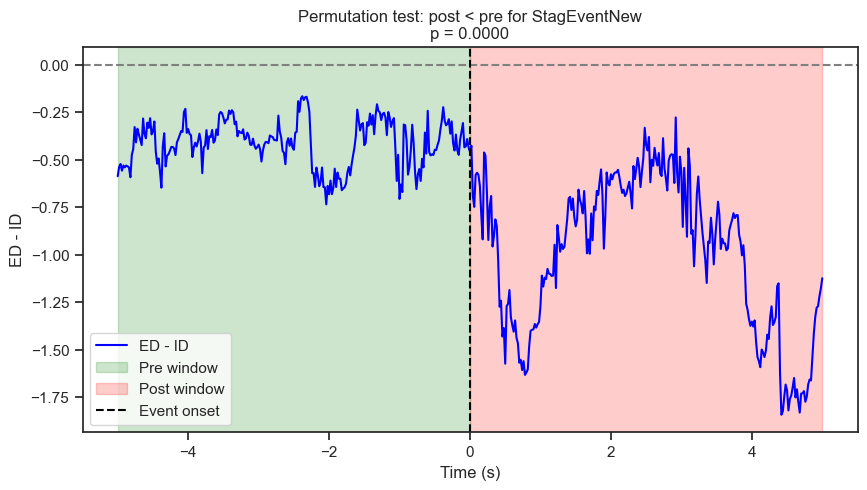

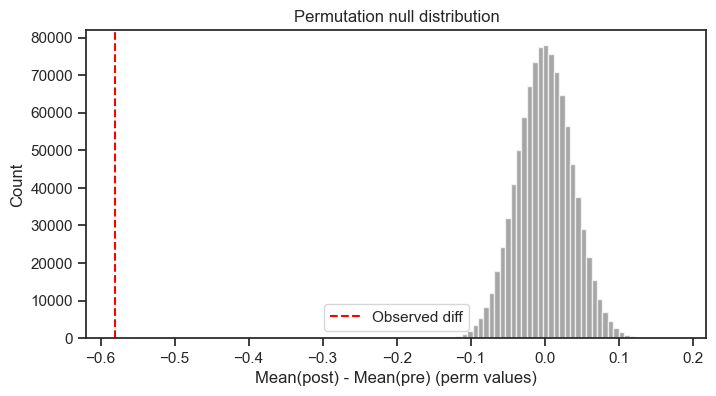

Observed mean difference (post - pre): -0.5812
Permutation p-value: 0.0000


In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def permutation_test_pre_post(buffer_file, event_name, modalities, pre_window=(-5,0), post_window=(0,5), n_permutations=10000):
    """
    Permutation test for ED-ID: tests whether post-onset ED-ID is significantly lower than pre-onset.

    Parameters
    ----------
    buffer_file : str
        Path to CSV buffer file.
    event_name : str
        Name of the event to analyze.
    modalities : list of str
        List of modalities used for ID calculation.
    pre_window : tuple
        Time window (sec) for pre-onset.
    post_window : tuple
        Time window (sec) for post-onset.
    n_permutations : int
        Number of permutations for null distribution.

    Returns
    -------
    p_value : float
        Permutation-based p-value for post < pre.
    """

    # --- Load buffer file ---
    df = pd.read_csv(buffer_file)
    df = df[df['event_name'] == event_name]

    if df.empty:
        raise ValueError(f"No data for event '{event_name}' in buffer file.")

    time = df['time_sec'].values
    ed = df['ED'].values

    # --- Compute ED - ID ---
    if 'SteeringInput' in modalities:
        id_curve = np.where(time <= 0, len(modalities)-1, len(modalities))
    else:
        id_curve = np.full_like(time, len(modalities))

    ed_minus_id = ed - id_curve

    # --- Select pre/post windows ---
    pre_idx = (time >= pre_window[0]) & (time < pre_window[1])
    post_idx = (time >= post_window[0]) & (time <= post_window[1])

    pre_vals = ed_minus_id[pre_idx]
    post_vals = ed_minus_id[post_idx]

    obs_diff = np.mean(post_vals) - np.mean(pre_vals)

    # --- Permutation test ---
    combined = np.concatenate([pre_vals, post_vals])
    n_pre = len(pre_vals)
    perm_diffs = []

    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_pre = combined[:n_pre]
        perm_post = combined[n_pre:]
        perm_diffs.append(np.mean(perm_post) - np.mean(perm_pre))

    perm_diffs = np.array(perm_diffs)

    # p-value: fraction of null >= observed difference (post < pre)
    p_value = np.mean(perm_diffs <= obs_diff)

    # --- Plot ---
    plt.figure(figsize=(10,5))
    plt.plot(time, ed_minus_id, label="ED - ID", color='blue')
    plt.axvspan(pre_window[0], pre_window[1], color='green', alpha=0.2, label='Pre window')
    plt.axvspan(post_window[0], post_window[1], color='red', alpha=0.2, label='Post window')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='black', linestyle='--', label='Event onset')
    plt.xlabel("Time (s)")
    plt.ylabel("ED - ID")
    plt.title(f"Permutation test: post < pre for {event_name}\np = {p_value:.4f}")
    plt.legend()
    plt.show()

    # --- Plot null distribution ---
    plt.figure(figsize=(8,4))
    plt.hist(perm_diffs, bins=50, color='gray', alpha=0.7)
    plt.axvline(obs_diff, color='red', linestyle='--', label='Observed diff')
    plt.xlabel("Mean(post) - Mean(pre) (perm values)")
    plt.ylabel("Count")
    plt.title("Permutation null distribution")
    plt.legend()
    plt.show()

    print(f"Observed mean difference (post - pre): {obs_diff:.4f}")
    print(f"Permutation p-value: {p_value:.4f}")

    return p_value, obs_diff, perm_diffs

# =======================
# Example call
buffer_file = "data/ed_buffer_5modalities_warnings.csv"
event_name = "StagEventNew"
modalities = ['EyeDirWorldCombined.x','EyeDirWorldCombined.y','NoseVector.x','NoseVector.y','SteeringInput']
n_permutations=1000000
p_value, obs_diff, perm_diffs = permutation_test_pre_post(buffer_file, event_name, modalities, n_permutations=n_permutations)


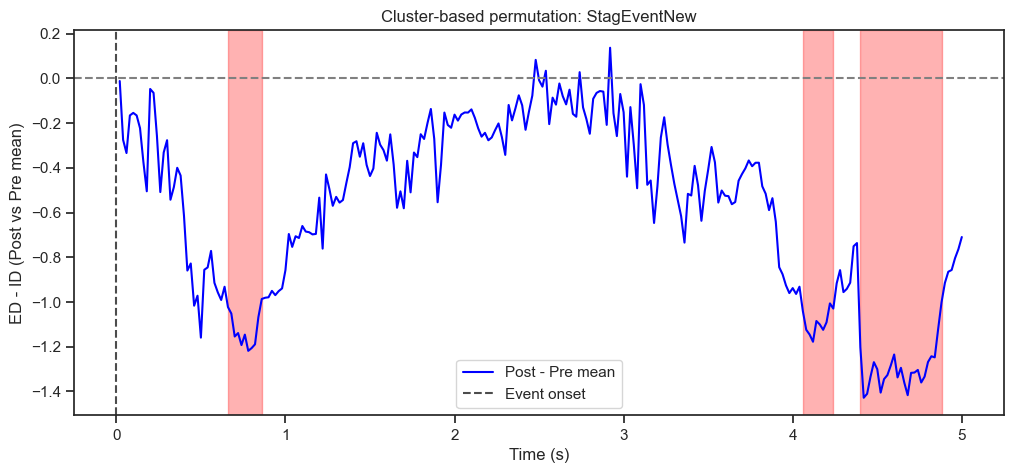

Significant clusters (start_idx, end_idx): [(32, 42), (202, 211), (219, 243)]
Cluster masses: [5.957451530827797, 5.09124145886536, 17.877129943957183]


In [207]:

def cluster_permutation_sections(
    buffer_file,
    event_name,
    modalities,
    threshold_std=1,
    n_permutations=1000
):
    """
    Cluster-based permutation test to find significant sections of the post ED-ID curve
    compared to pre baseline.

    Parameters
    ----------
    buffer_file : str
        Path to ED buffer file.
    event_name : str
        Event name to analyze.
    modalities : list
        List of modalities (needed for ID curve).
    threshold_std : float
        Threshold in standard deviations for defining clusters.
    n_permutations : int
        Number of permutations for null distribution.

    Returns
    -------
    sig_clusters : list of (start_idx, end_idx)
        Significant clusters in post period.
    cluster_stats : list of float
        Mass (sum of deviations) of significant clusters.
    """

    # --- Load data ---
    df = pd.read_csv(buffer_file)
    df = df[df['event_name'] == event_name]

    if df.empty:
        print(f"No data found for event '{event_name}' in buffer file.")
        return [], []

    # --- Compute ED - ID ---
    ed_curves = {}
    for cond, group in df.groupby('condition'):
        time = group['time_sec'].values
        ed = group['ED'].values

        if 'SteeringInput' in modalities:
            id_curve = np.where(time <= 0, len(modalities)-1, len(modalities))
        else:
            id_curve = np.full_like(time, len(modalities))

        ed_curves[cond] = ed - id_curve

    ED_obs = np.mean(np.vstack(list(ed_curves.values())), axis=0)
    T = len(ED_obs)

    # --- Split pre/post ---
    pre_idx = time <= 0
    post_idx = time > 0
    pre_curve = ED_obs[pre_idx]
    post_curve = ED_obs[post_idx]

    # Observed difference curve
    obs_diff = post_curve - np.mean(pre_curve)

    # --- Build null distribution of cluster masses ---
    null_max_masses = []
    for _ in range(n_permutations):
        # Shuffle labels
        combined = np.concatenate([pre_curve, post_curve])
        np.random.shuffle(combined)
        pre_perm = combined[:pre_curve.size]
        post_perm = combined[pre_curve.size:]
        diff_perm = post_perm - np.mean(pre_perm)

        # Threshold
        dev = diff_perm - np.mean(diff_perm)
        thresh = threshold_std * np.std(diff_perm)
        above = dev < -thresh  # looking for more negative post

        # Cluster mass (sum of deviations)
        cluster_mass = 0
        max_mass = 0
        for val, d in zip(above, dev):
            if val:
                cluster_mass += abs(d)
            else:
                max_mass = max(max_mass, cluster_mass)
                cluster_mass = 0
        max_mass = max(max_mass, cluster_mass)
        null_max_masses.append(max_mass)

    null_max_masses = np.array(null_max_masses)
    thresh_mass = np.percentile(null_max_masses, 99)

    # --- Identify observed clusters ---
    dev = obs_diff - np.mean(obs_diff)
    thresh = threshold_std * np.std(obs_diff)
    above = dev < -thresh

    sig_clusters = []
    cluster_stats = []
    cluster_mass = 0
    cluster_start = None

    for t, val in enumerate(above):
        if val:
            if cluster_start is None:
                cluster_start = t
            cluster_mass += abs(dev[t])
        else:
            if cluster_start is not None:
                if cluster_mass > thresh_mass:
                    sig_clusters.append((cluster_start, t-1))
                    cluster_stats.append(cluster_mass)
                cluster_start = None
                cluster_mass = 0

    if cluster_start is not None and cluster_mass > thresh_mass:
        sig_clusters.append((cluster_start, post_curve.size-1))
        cluster_stats.append(cluster_mass)

    # --- Plot ---
    plt.figure(figsize=(12, 5))
    plt.plot(time[post_idx], obs_diff, label="Post - Pre mean", color="blue")
    plt.axhline(0, color="gray", linestyle="--")
    plt.axvline(0, color="black", linestyle="--", alpha=0.7, label="Event onset")
    for (start, end) in sig_clusters:
        plt.axvspan(time[post_idx][start], time[post_idx][end], color="red", alpha=0.3)
    plt.xlabel("Time (s)")
    plt.ylabel("ED - ID (Post vs Pre mean)")
    plt.title(f"Cluster-based permutation: {event_name}")
    plt.legend()
    plt.show()

    return sig_clusters, cluster_stats


# ==== CALL BLOCK ====
buffer_file = "data/ed_buffer_5modalities_warnings.csv"
event_name = "StagEventNew"
modalities = ['EyeDirWorldCombined.x','EyeDirWorldCombined.y','NoseVector.x','NoseVector.y','SteeringInput']

sig_clusters, cluster_stats = cluster_permutation_sections(
    buffer_file,
    event_name,
    modalities,
    threshold_std=1,
    n_permutations=10000
)

print("Significant clusters (start_idx, end_idx):", sig_clusters)
print("Cluster masses:", cluster_stats)

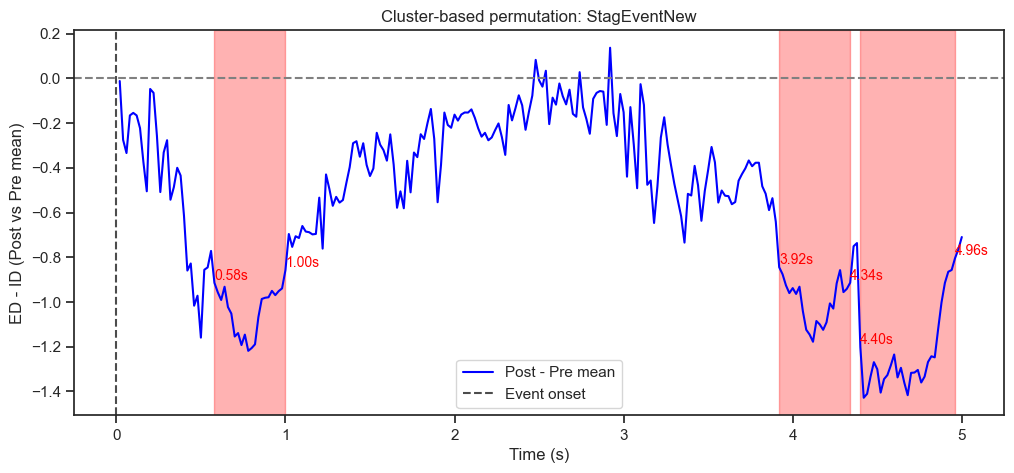

Significant clusters (start_idx, end_idx): [(28, 49), (195, 216), (219, 247)]
Cluster masses: [22.792461293959313, 21.945681160882977, 35.89629649725021]


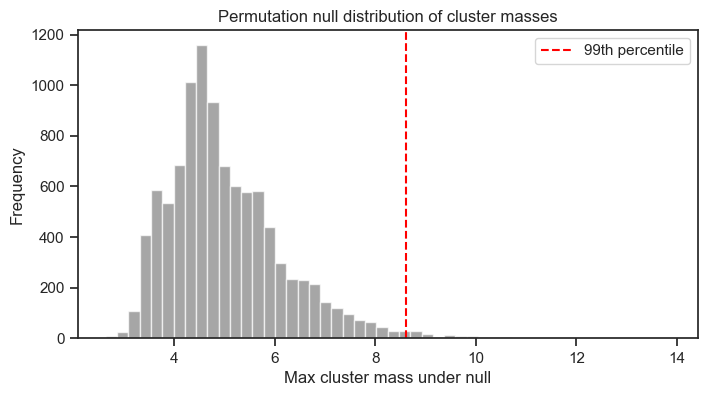

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def cluster_permutation_sections_fixed(
    buffer_file,
    event_name,
    modalities,
    threshold_std=1,
    n_permutations=1000
):
    """
    Cluster-based permutation test to find significant sections of the post ED-ID curve
    compared to pre baseline (one-sided: post < pre mean).

    Parameters
    ----------
    buffer_file : str
        Path to ED buffer file.
    event_name : str
        Event name to analyze.
    modalities : list
        List of modalities (needed for ID curve).
    threshold_std : float
        Threshold in standard deviations for defining clusters.
    n_permutations : int
        Number of permutations for null distribution.

    Returns
    -------
    sig_clusters : list of (start_idx, end_idx)
        Significant clusters in post period.
    cluster_stats : list of float
        Mass (sum of deviations) of significant clusters.
    """

    # --- Load data ---
    df = pd.read_csv(buffer_file)
    df = df[df['event_name'] == event_name]

    if df.empty:
        print(f"No data found for event '{event_name}' in buffer file.")
        return [], []

    # --- Compute ED - ID ---
    ed_curves = {}
    for cond, group in df.groupby('condition'):
        time = group['time_sec'].values
        ed = group['ED'].values

        # ID curve
        if 'SteeringInput' in modalities:
            id_curve = np.where(time <= 0, len(modalities)-1, len(modalities))
        else:
            id_curve = np.full_like(time, len(modalities))

        ed_curves[cond] = ed - id_curve

    ED_obs = np.mean(np.vstack(list(ed_curves.values())), axis=0)
    T = len(ED_obs)

    # --- Split pre/post ---
    pre_idx = time <= 0
    post_idx = time > 0
    pre_curve = ED_obs[pre_idx]
    post_curve = ED_obs[post_idx]

    # Observed difference vs pre mean
    obs_diff = post_curve - np.mean(pre_curve)

    # --- Build null distribution of max cluster masses ---
    null_max_masses = []
    for _ in range(n_permutations):
        shuffled = np.random.permutation(obs_diff)  # shuffle deviations within post
        thresh = threshold_std * np.std(shuffled)
        above = shuffled < -thresh  # one-sided: more negative than threshold

        cluster_mass = 0
        max_mass = 0
        for val, d in zip(above, shuffled):
            if val:
                cluster_mass += abs(d)
            else:
                max_mass = max(max_mass, cluster_mass)
                cluster_mass = 0
        max_mass = max(max_mass, cluster_mass)
        null_max_masses.append(max_mass)

    null_max_masses = np.array(null_max_masses)
    thresh_mass = np.percentile(null_max_masses, 95)

    # --- Identify observed clusters ---
    thresh = threshold_std * np.std(obs_diff)
    above = obs_diff < -thresh

    sig_clusters = []
    cluster_stats = []
    cluster_mass = 0
    cluster_start = None

    for t, val in enumerate(above):
        if val:
            if cluster_start is None:
                cluster_start = t
            cluster_mass += abs(obs_diff[t])
        else:
            if cluster_start is not None:
                if cluster_mass > thresh_mass:
                    sig_clusters.append((cluster_start, t-1))
                    cluster_stats.append(cluster_mass)
                cluster_start = None
                cluster_mass = 0

    if cluster_start is not None and cluster_mass > thresh_mass:
        sig_clusters.append((cluster_start, post_curve.size-1))
        cluster_stats.append(cluster_mass)

    # --- Plot with cluster timestamps ---
    plt.figure(figsize=(12, 5))
    plt.plot(time[post_idx], obs_diff, label="Post - Pre mean", color="blue")
    plt.axhline(0, color="gray", linestyle="--")
    plt.axvline(0, color="black", linestyle="--", alpha=0.7, label="Event onset")

    for (start, end) in sig_clusters:
        plt.axvspan(time[post_idx][start], time[post_idx][end], color="red", alpha=0.3)
        plt.text(time[post_idx][start], obs_diff[start],
                f"{time[post_idx][start]:.2f}s", color='red', fontsize=10, verticalalignment='bottom')
        plt.text(time[post_idx][end], obs_diff[end],
                f"{time[post_idx][end]:.2f}s", color='red', fontsize=10, verticalalignment='bottom')

    plt.xlabel("Time (s)")
    plt.ylabel("ED - ID (Post vs Pre mean)")
    plt.title(f"Cluster-based permutation: {event_name}")
    plt.legend()
    plt.show()

    return sig_clusters, cluster_stats, null_max_masses


# ==== CALL BLOCK ====
buffer_file = "data/ed_buffer_5modalities_warnings.csv"
event_name = "StagEventNew"
modalities = ['EyeDirWorldCombined.x','EyeDirWorldCombined.y','NoseVector.x','NoseVector.y','SteeringInput']

sig_clusters, cluster_stats, null_distribution = cluster_permutation_sections_fixed(
    buffer_file,
    event_name,
    modalities,
    threshold_std=2,   # adjust to tune sensitivity
    n_permutations=10000
)

print("Significant clusters (start_idx, end_idx):", sig_clusters)
print("Cluster masses:", cluster_stats)

# Optional: visualize null distribution
plt.figure(figsize=(8,4))
plt.hist(null_distribution, bins=50, color='gray', alpha=0.7)
plt.axvline(np.percentile(null_distribution,99), color='red', linestyle='--', label="99th percentile")
plt.xlabel("Max cluster mass under null")
plt.ylabel("Frequency")
plt.title("Permutation null distribution of cluster masses")
plt.legend()
plt.show()
